5\. Assignment: Timeseries Forecasting Deep Learning Approach
----------------------------------------------------

### Objective

Deep learning models, such as Recurrent Neural Networks (RNNs) and Long Short-Term Memory (LSTM) networks, can learn intricate patterns, making them suitable for high-dimensional financial data. Unlike traditional methods, they can deal with highly nonlinear patterns.

# Assignment
Follow example implementation [here(Youtube video)](https://www.youtube.com/watch?v=hpfQE0bTeA4) to perform **LSTM Price Movement Predictions For Trading Algorithms**.
How does that differ to the approaches seen today?

##### Steps and marking criteria:

| Category                          | Criteria                                                                                                                              | Points          |
| --------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------- | --------------- |
| Data Preparation                  | Loads the dataset correctly, handles missing values, and prepares time series data for LSTM (e.g., normalization, sequence creation). | 2               |
| LSTM Model Implementation         | Implements LSTM based on the provided YouTube example, ensuring correct model architecture and training process.                      | 2               |
| Performance Evaluation            | Evaluates model performance using appropriate metrics (e.g., RMSE, accuracy, loss curves) and interprets the results.                 | 2               |
| Comparison to Traditional Methods | Clearly explains how the LSTM approach differs from traditional time series forecasting methods (ARIMA, Prophet, etc.).               | 2               |
| Code Quality & Documentation      | Code is well-structured, readable, and includes Markdown comments explaining each step.                                               | 1               |
| Business/Trading Insights         | Discusses practical implications for trading algorithms, including strengths and weaknesses of LSTM for price prediction.             | 1               |
| Extra Analysis (Optional)         | Experiments with hyperparameter tuning, alternative architectures (e.g., GRU), or additional feature engineering. (Bonus)             | (+1)            |
|                                   | **Total:**                                                                                                                                | **10 + 1 (max 10)** |


---

### **Notebook Structure:**
0. **Load Dataset**

1. **Data Preparation**
- Handle missing values
- Feature Engineering 

2. **LSTM Model Implementation**
- Model Architecture
- Train/Fit model
- Model Evaluation
- Forecast next X days

3. **Model Comparisons**
- ARIMA Model Implementation
- Prophet Model Implementation
    - Univariate Prophet Model
    - Multivariate Prophet Model  
- Models Comparisons

4. **Business Trading Insights**

5. **Experiementation with Architecture, Hyperparameter tuning & Additional features (Optional)**


### Import Libraries

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Used for our model evaluations on the TimeSeries models (i.e. regression models)
from model_evaluations import model_evaluation_report_regression

pd.set_option('max_colwidth', 800)
pd.set_option('display.max_columns', None)

# Retrieving today's date
st = datetime.now().strftime('%Y-%m-%d')

# Working locally on Jupyter Notebook, parent folder is one folder up (using the folder structure shared at the beginning of the course)
path_python_material = ".."

---
# 0. Load Dataset
We will be retrieving Apple's stock prices using an API with the yfinance library, using Yahoo Finance's public APIs.

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

DataFrame of AAPL


,Close,High,Low,Open,Volume,TargetNextClose
Date,,,,,,
2015-01-02,24.320435,24.789804,23.879983,24.778681,212818400,23.635286
2015-01-05,23.635286,24.169166,23.448429,24.089084,257142000,23.637514
2015-01-06,23.637514,23.897780,23.274920,23.699800,263188400,23.968960
2015-01-07,23.968960,24.069062,23.735387,23.846612,160423600,24.889904
2015-01-08,24.889904,24.947741,24.180289,24.298189,237458000,24.916597
...,...,...,...,...,...,...
2025-03-07,239.070007,241.369995,234.759995,235.110001,46273600,227.479996
2025-03-10,227.479996,236.160004,224.220001,235.539993,72071200,220.839996
2025-03-11,220.839996,225.839996,217.449997,223.809998,76137400,216.979996


Shape of Stock data : AAPL


(2564, 6)

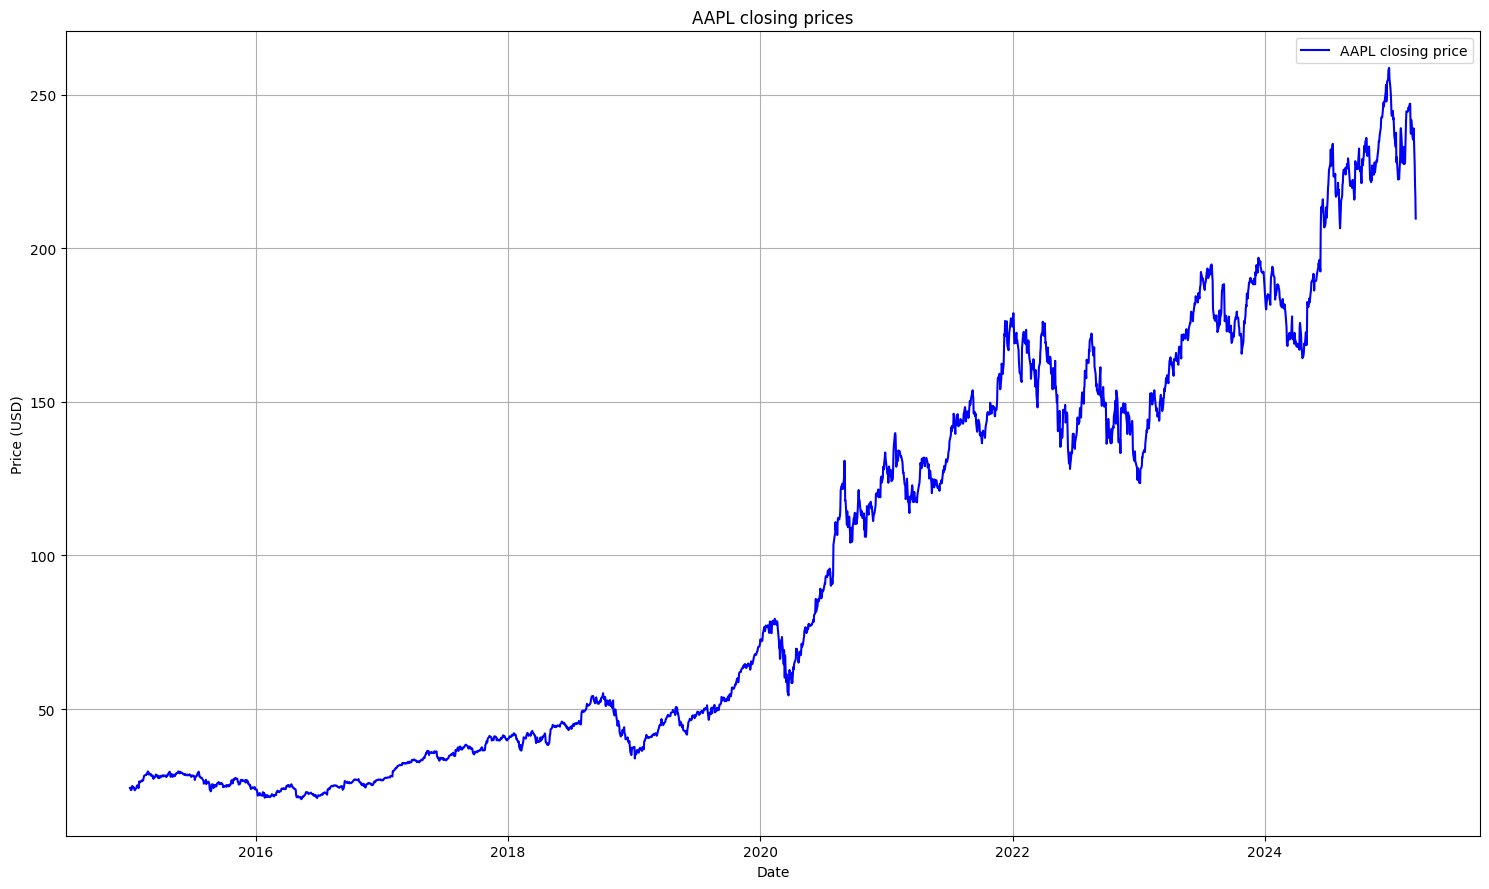

In [2]:
import yfinance as yf

# Define the ticker symbol for Apple Inc.
chosen_stock = 'AAPL'

# Use yfinance to download the stock data
appl_stock_data = yf.download(chosen_stock, start='2015-01-01', end=st, interval='1d', multi_level_index = False)

# Create a feature for TargetNextClose
# Example: taking the 'Close' value for a current day, and shifting it back one day
# This will be our target variable
appl_stock_data['TargetNextClose'] = appl_stock_data['Close'].shift(-1)

# We will have a null value for the very last TargetNextClose, so we will trim of the last record
appl_stock_data = appl_stock_data[:-1]

# Display the first few rows of the data
print(f"DataFrame of {chosen_stock}")
display(appl_stock_data)

# Look at the shape of the data
print(f"Shape of Stock data : {chosen_stock}")
display(appl_stock_data.shape)

def plot_stock_price(stock_data, ticker, color):
    
     # Plot the closing price data
    plt.figure(figsize=(15, 9))
    plt.plot(stock_data['Close'], label=f"{ticker} closing price", color=color)
    plt.title(f"{ticker} closing prices")
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    mng = plt.get_current_fig_manager()
    mng.full_screen_toggle()
    plt.tight_layout()
    plt.grid(True)
    plt.show()

plot_stock_price(appl_stock_data, chosen_stock, "blue")


### Observation

We see our APPLE stock has a **Multiplicative** time series, as the fluctuations increases as the trend increases.

---
# 1. Data Preparation



In [3]:
# Ensure the index is a DatetimeIndex
appl_stock_data.index = pd.to_datetime(appl_stock_data.index)


In [4]:
# Set the frequency of the time series to 'B' (business day)
appl_stock_data = appl_stock_data.asfreq('B')

appl_stock_data

,Close,High,Low,Open,Volume,TargetNextClose
Date,,,,,,
2015-01-02,24.320435,24.789804,23.879983,24.778681,212818400.0,23.635286
2015-01-05,23.635286,24.169166,23.448429,24.089084,257142000.0,23.637514
2015-01-06,23.637514,23.897780,23.274920,23.699800,263188400.0,23.968960
2015-01-07,23.968960,24.069062,23.735387,23.846612,160423600.0,24.889904
2015-01-08,24.889904,24.947741,24.180289,24.298189,237458000.0,24.916597
...,...,...,...,...,...,...
2025-03-07,239.070007,241.369995,234.759995,235.110001,46273600.0,227.479996
2025-03-10,227.479996,236.160004,224.220001,235.539993,72071200.0,220.839996
2025-03-11,220.839996,225.839996,217.449997,223.809998,76137400.0,216.979996


### Check for null/nan values

In [5]:
appl_stock_data_na = appl_stock_data[pd.isnull(appl_stock_data['Close']) == True]

appl_stock_data_na

,Close,High,Low,Open,Volume,TargetNextClose
Date,,,,,,
2015-01-19,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-16,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-03,NaN,NaN,NaN,NaN,NaN,NaN
2015-05-25,NaN,NaN,NaN,NaN,NaN,NaN
2015-07-03,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2024-12-25,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-01,NaN,NaN,NaN,NaN,NaN,NaN
2025-01-09,NaN,NaN,NaN,NaN,NaN,NaN


### Observation
- We have 96 records to date that are null.
- Perform a forward-fill (e.g., propagating the last valid observation to next valid observation)
- e.g., Next Observation Carried Backward(NOCB) using ffill()

In [6]:
# Take a copy of initial stock data
appl_stock_data_ffil = appl_stock_data.copy()

# Foward-fill each relevant column in stock data
for col in appl_stock_data_ffil.columns:

    appl_stock_data_ffil[col] = appl_stock_data_ffil[col].ffill()


### Inspecting new forward-filled data - to ensure nulls/nans have been filled


In [7]:
nas = appl_stock_data_ffil['Close'].isna().sum()
print(f"Null values: {nas} \n \n")

Null values: 0 
 



### Checks if weekends included in initial stock data

In [8]:
weekends = appl_stock_data.index[appl_stock_data.index.weekday >= 5]
   
if len(weekends) > 0:
    print("Weekends are included in the time series.")
    print(weekends)  # Optionally print which dates are weekends
else:
    print("No weekends are included in the time series.")

No weekends are included in the time series.


### Preparing sub-dataset of the null/nans records that have been forward-filled

In [9]:
# DataFrame of the Null records that have now been forward-filled
appl_stock_data_fil_na = appl_stock_data_ffil[appl_stock_data_ffil.index.isin(appl_stock_data_na.index)]

appl_stock_data_fil_na

,Close,High,Low,Open,Volume,TargetNextClose
Date,,,,,,
2015-01-19,23.577444,23.931140,23.401709,23.808792,314053200.0,24.184738
2015-02-16,28.380480,28.425145,28.061121,28.425145,217088800.0,28.547976
2015-04-03,27.987429,28.041027,27.735069,27.922663,128880400.0,28.440783
2015-05-25,29.723490,29.819924,29.467833,29.512688,182384000.0,29.068655
2015-07-03,28.355503,28.411568,28.205247,28.353260,108844000.0,28.256830
...,...,...,...,...,...,...
2024-12-25,257.916443,257.926411,255.009620,255.209412,23234700.0,258.735504
2025-01-01,250.144974,253.001833,249.156056,252.162760,39480700.0,243.582199
2025-01-09,242.433441,243.442342,239.786358,241.654299,37628900.0,236.589874


### Observation
We see our 96 *NULL* records for all features have been forward-filled 

### Generating a Time-series plot, indicating gaps in the initial stock data, together with the forward-filled data points

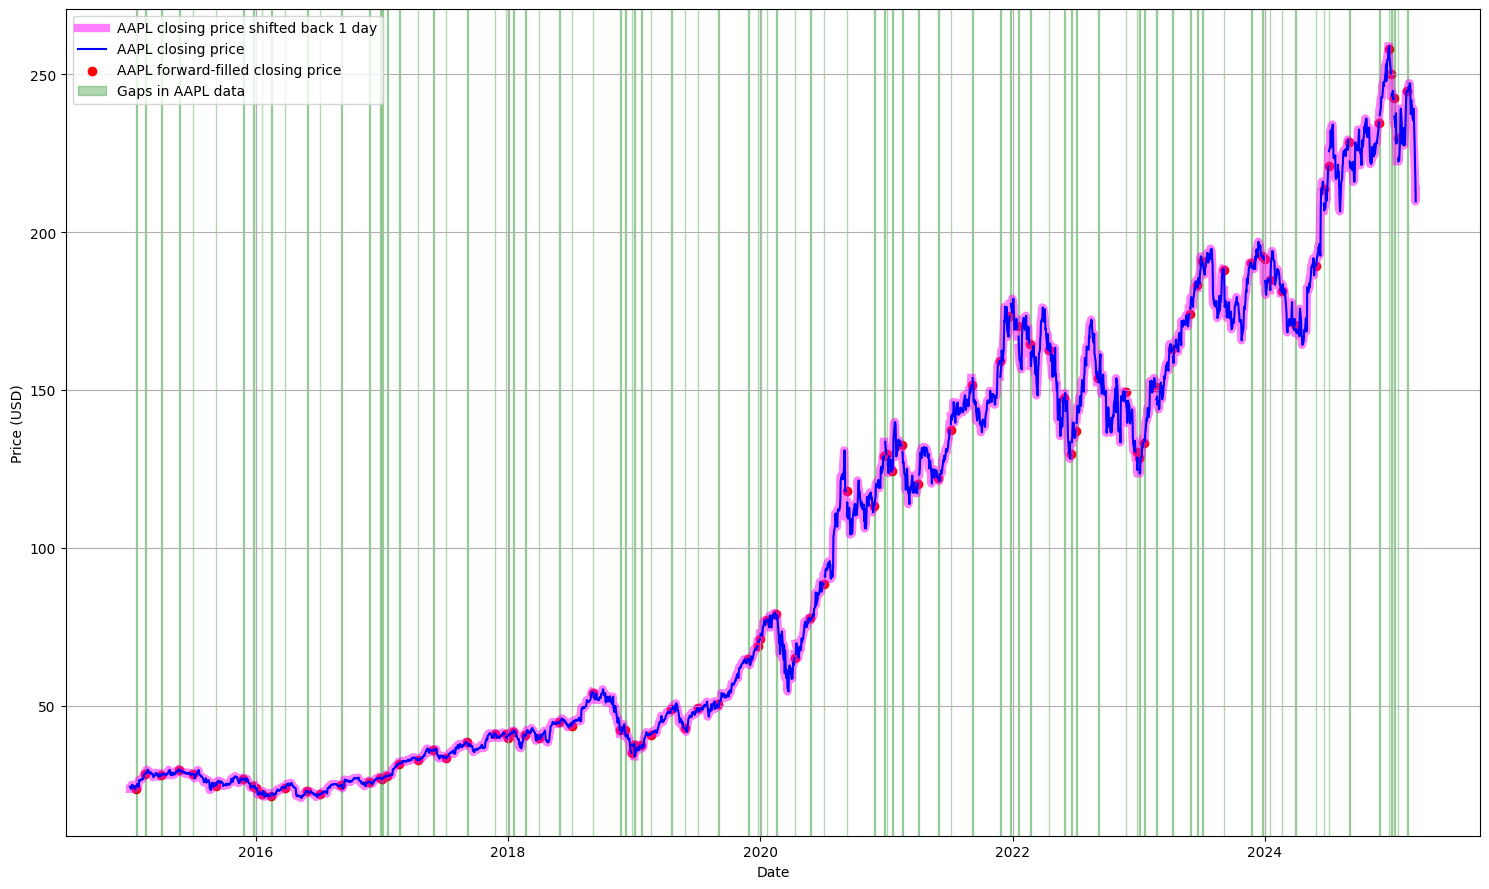

In [10]:
# Plot the closing price data
plt.figure(figsize=(15, 9))

# Line plot of the APPL stock data shifted back one day
plt.plot(appl_stock_data['TargetNextClose'], label=f"{chosen_stock} closing price shifted back 1 day", color="magenta", lw=6, alpha=0.5)

# Line plot of the APPL stock data
plt.plot(appl_stock_data['Close'], label=f"{chosen_stock} closing price", color="blue")

# Scatter plot of the imputed missing records using ffill 
plt.scatter(x=appl_stock_data_fil_na.index, y=appl_stock_data_fil_na['Close'], label=f"{chosen_stock} forward-filled closing price", color="red")

# Getting first index record of `appl_stock_data_fil_na` -- to use for our plotting purposes
first_ymd = appl_stock_data_fil_na.index[0]

# Vertical lines indicating the gaps in the AAPL stock data, which have now been ffill
for ymd in appl_stock_data_fil_na.index:

        # Plotting Vertical lines to indicate gaps in the stock data which have now been filled 
        plt.axvspan( ymd, ymd + pd.offsets.Day(2), color='green', alpha=0.3, label=f"Gaps in {chosen_stock} data " if ymd == first_ymd else "")

plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.tight_layout()
plt.grid(True)
plt.show()

### Observation
The *(Green-vertical-lines)* are the 96 NULL records that have now been forward-filled with values represented by the *(Red-dots)*

The *(Blue-Line)* is the actual Close stcok price

The *(Magenta-Line)* the actual Close price shifted back one day # Our Target


## 1.2 Feature Engineering

Going to scale the dataset using MinMaxScaler in the range 0-1

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Initialise scaling
mms = MinMaxScaler(feature_range=(0,1))

# Define are target feature i.e., Close price
target_col = ['TargetNextClose']

# Define our inut features i.e., open, volumne, ...etc
x_col = [col for col in appl_stock_data_ffil.columns if col != target_col[0]]

# Transform the input features
X_mms = mms.fit_transform(appl_stock_data_ffil[x_col])

# Transformed input features into Dataframe --- Just for clarity to ensure our data has properly been transformed
X_mms = pd.DataFrame(X_mms, columns=x_col, index=appl_stock_data_ffil.index)

# Transform target feature
y_mms = mms.fit_transform(appl_stock_data_ffil[target_col])

# Transformed target feature into Dataframe --- Just for clarity to ensure our data has properly been transformed 
# Also, this will help us inverse_tranform our predicted values back to real values
y_mms = pd.DataFrame(y_mms, columns=target_col,  index=appl_stock_data_ffil.index)

# DataFrame of the transformed features
df_stock_data_mms = pd.concat([X_mms, y_mms], axis=1)

display(df_stock_data_mms)

stock_data_mms = np.array(df_stock_data_mms)

# initialize empty list to hold input features
X = []

# To capture time-based trends, we organize the data into sequences of <LOOK_BACK> days, which the LSTM model can then learn from.
# Setting the number of previous time-steps to consider for each sample
LOOK_BACK = 15 # days

# Loop through each input feature, with chuncks of arrays in slices of <LOOK_BACK> 
# This converts the input features into array shape (num_of_records, LOOK_BACK, num_of_columns )
for i in range(LOOK_BACK, len(stock_data_mms)):
    X.append(stock_data_mms[i-LOOK_BACK:i,:len(appl_stock_data_ffil.columns)])

# Taking the Target feature from our scaled array
y = np.array(stock_data_mms[LOOK_BACK:,-1])

# shape (num_of_records, LOOK_BACK, num_of_columns )
y = np.reshape(y,(len(y),1))

# SPlit data in train : test ~ 80%
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = np.array(X_test), np.array(y_test)

# Shape Verification:
print("\n Shape verification ")
print(f"X_train Shape == {X_train.shape}")
print(f"X_test Shape = {X_test.shape}")
print(f"y_train Shape = {y_train.shape}")
print(f"y_test Shape = {y_test.shape}")

,Close,High,Low,Open,Volume,TargetNextClose
Date,,,,,,
2015-01-02,0.015315,0.015956,0.014373,0.017622,0.303048,0.012437
2015-01-05,0.012437,0.013358,0.012551,0.014716,0.373898,0.012446
2015-01-06,0.012446,0.012221,0.011819,0.013076,0.383564,0.013839
2015-01-07,0.013839,0.012938,0.013763,0.013695,0.219295,0.017707
2015-01-08,0.017707,0.016617,0.015641,0.015598,0.342434,0.017819
...,...,...,...,...,...,...
2025-03-07,0.917393,0.922774,0.904644,0.903938,0.036827,0.868708
2025-03-10,0.868708,0.900960,0.860148,0.905750,0.078065,0.840816
2025-03-11,0.840816,0.857750,0.831567,0.856321,0.084564,0.824602



 Shape verification 
X_train Shape == (2116, 15, 6)
X_test Shape = (529, 15, 6)
y_train Shape = (2116, 1)
y_test Shape = (529, 1)


### Observation
- We have set up the data to be in chuncks of LOOK_BACK days.
- This means, we use the data from the previous LOOK_BACK days to predict the following day.
- Example : We use the previous 15 LOOK_BACK days of data to predict the values on day 16.

- The Data that we are going to ingest into our Deep Learning model, will have the shape (<num_of_records> , <LOOK_BACK days> , <num_of_features>)
- With this shape, our Deep Learning model will train on reading data in chuncks of LOOK_BACK days, with num_of_features to make predictions for the following day.

- From the DataFrame, our target **Y** feature is the last column, that we want to predict.
- E.g., predicting the NextDay Close price using current day Close price and Other features


---
# 2. LSTM Model Implementation


## 2.1 Model Architecture


| Neural Network Type | Structure | Use Case | Links | Description |
| --- | --- | --- | --- | --- |
| **Recurrent Neural Network (RNN)** | LSTM → Dense (Linear) | Time Series Prediction | [lstm for time series example](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/) | Suitable for sequential data; LSTMs manage long-term dependencies in time series or text inputs. |


## 2.2 Train/Fit model

In [37]:
# Defining a overfitting function, to plot residuals between accuracy, loss and AUC

def plot_training_vs_overfitting(history, title):
    """Plot training and validation accuracy to detect overfitting """
    import matplotlib.pyplot as plt

    # Plot MSE
    plt.plot(history.history['mean_squared_error'], label='Train MSE')
    plt.plot(history.history['val_mean_squared_error'], label='Validation MSE')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()

    # Plot loss
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title(title)
    plt.grid(True)
    plt.show()



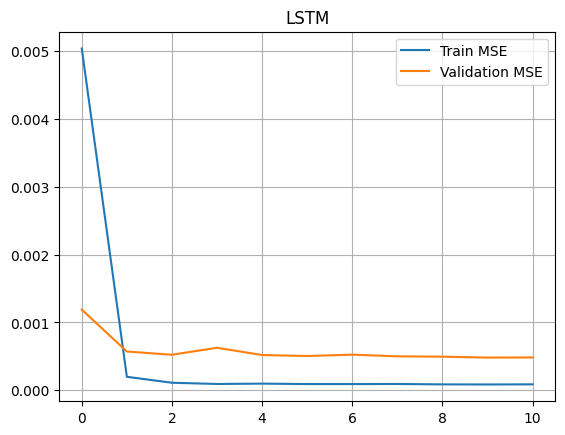

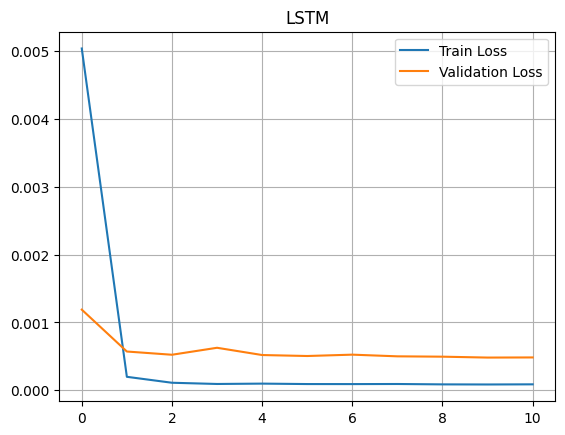

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_input (InputLayer)     [(None, 15, 6)]           0         
                                                                 
 first_layer (LSTM)          (None, 200)               165600    
                                                                 
 dense_layer (Dense)         (None, 1)                 201       
                                                                 
 output (Activation)         (None, 1)                 0         
                                                                 
Total params: 165,801
Trainable params: 165,801
Non-trainable params: 0
_________________________________________________________________


None

In [40]:
from keras.layers import LSTM
from keras.layers import Dense

from keras import optimizers
from keras.models import Model
from keras.layers import Input, Activation
import numpy as np
np.random.seed(10)

# For early stopping incase the model performance declines
from keras.callbacks import EarlyStopping

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Evaluation metric to watch 
    mode='max',
    patience=10,               # Stop if no improvement after <X> epochs
    restore_best_weights=True  # Restore the model weights at the best epoch
)

# Shape of input is based on previous timesteps <backcandles> and num_of_input features/cols
lstm_input = Input(shape=(X_train.shape[1], X_train.shape[2]), name='lstm_input')

# 200 Neurons for first layer
inputs = LSTM(200, name='first_layer')(lstm_input)

# Dense Layer for output
inputs = Dense(1, name='dense_layer')(inputs)

# Output layer with linear activation
output = Activation('linear', name='output')(inputs)

# Define Model
model = Model(inputs=lstm_input, outputs=output)

adam = optimizers.Adam()

model.compile(optimizer=adam, loss='mse', metrics=['mean_squared_error'])

history = model.fit(x=X_train, y=y_train, 
                    batch_size=64, 
                    epochs=100,  
                    validation_split = 0.2, 
                    verbose=0 , 
                    callbacks=[early_stopping]
                    )

#Display model performance
plot_training_vs_overfitting(history, 'LSTM')

# Display Model summary
display(history.model.summary())



### Observation
- We have created a LSTM model based on 200 neurons, using LOOK_BACK days to predict the following day.
- We ran on 100 epochs, with EarlyStopping by after 10 epochs to avoid overfits, evaluation on 'Loss'
- Also, from the curves, we see it reaches up to 10 epochs to avoid overfitting.

17/17 [==============================] - 0s 4ms/step


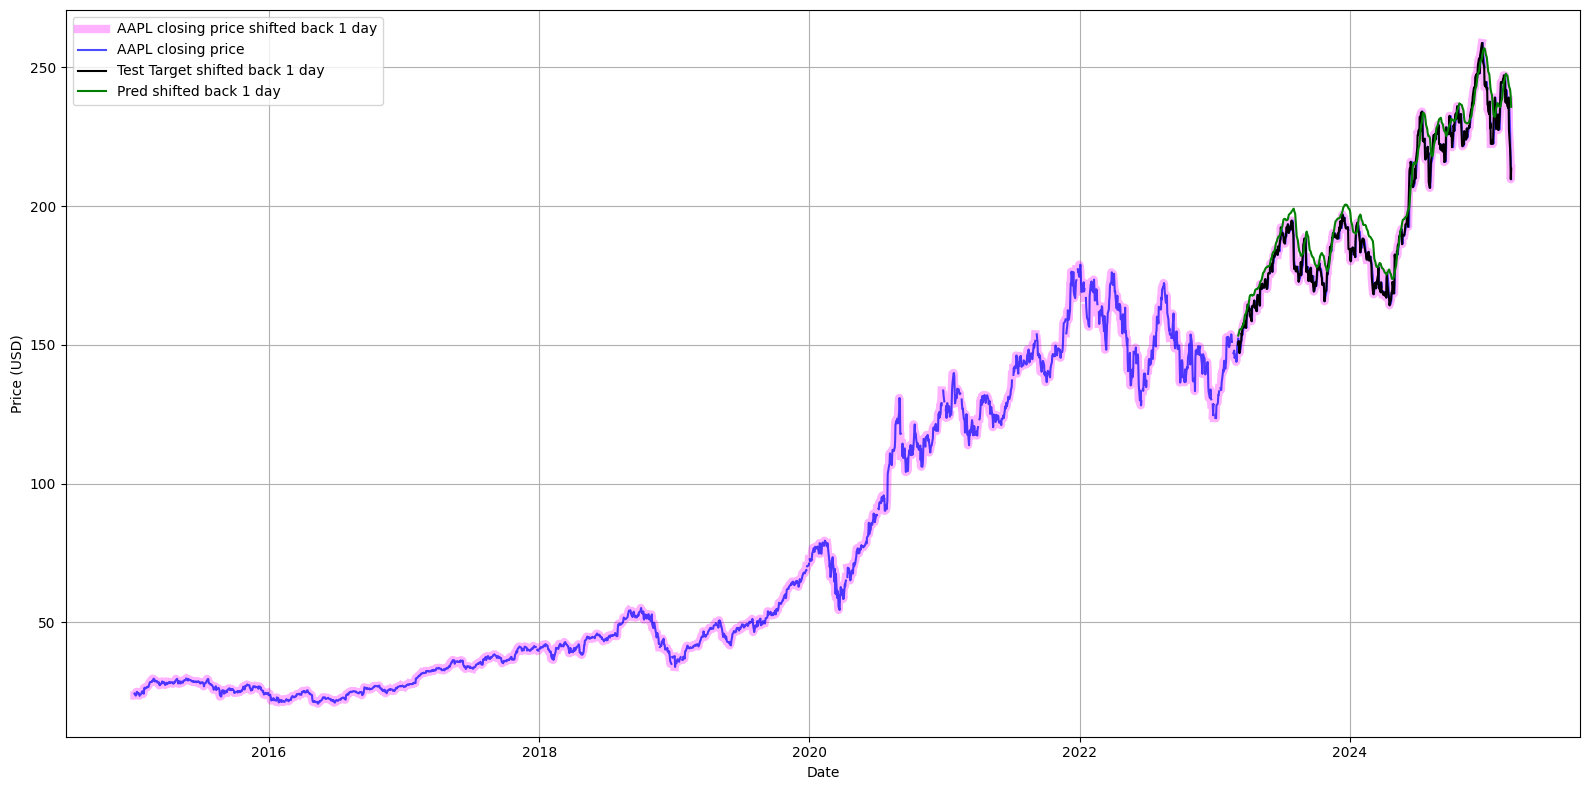

In [41]:
# Make Predictions
y_pred = history.model.predict(X_test)

# Plot of Predictions vs Test Data (inversely transormed) 
y_pred_trn = pd.DataFrame(mms.inverse_transform(y_pred), columns=['y_pred'] , index=df_stock_data_mms.index[train_size+LOOK_BACK:])

y_test_trn = pd.DataFrame(mms.inverse_transform(y_test), columns=['y_test'] , index=df_stock_data_mms.index[train_size+LOOK_BACK:]) 


plt.figure(figsize=(16,8))

# Line plot of the APPL stock data shifted back one day
plt.plot(appl_stock_data['TargetNextClose'], label=f"{chosen_stock} closing price shifted back 1 day", color="magenta", lw=6, alpha=0.3)

# Line plot of the APPL stock data
plt.plot(appl_stock_data['Close'], label=f"{chosen_stock} closing price", color="blue", alpha=0.7)

plt.plot(y_test_trn, color = 'black', label = 'Test Target shifted back 1 day')
plt.plot(y_pred_trn, color = 'green', label = 'Pred shifted back 1 day')

plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.tight_layout()
plt.grid(True)
plt.show()



## 2.3 Model Evaluation

In [42]:
print(" ... Model Evaluation test data ... ")
# Now evaluate the model on the test data
test_loss = history.model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)

model_evaluation_report_regression(y_test,y_pred )

print(" \n ... Model Evaluation train data ... ")
# Now evaluate the model on the test data
train_loss = history.model.evaluate(X_train, y_train)
print("Train Loss: ", train_loss)

from model_evaluations import model_evaluation_report_regression

y_target = y
y_pred_full = history.model.predict(np.array(X))

model_evaluation_report_regression(y_target,y_pred_full )


 ... Model Evaluation test data ... 
17/17 [==============================] - 0s 4ms/step - loss: 0.0010 - mean_squared_error: 0.0010    
Test Loss:  [0.0010258289985358715, 0.0010258289985358715]

 ... Evaluation Metrics for Regression ... 
MAE: 0.025860364580893174
MSE: 0.0010258289850606243
RMSE: 0.032028565142082535
R-squared: 0.9209194081779428
 
 ... Model Evaluation train data ... 
67/67 [==============================] - 0s 4ms/step - loss: 4.1768e-04 - mean_squared_error: 4.1768e-04
Train Loss:  [0.0004176761722192168, 0.0004176761722192168]
83/83 [==============================] - 0s 4ms/step

 ... Evaluation Metrics for Regression ... 
MAE: 0.017176297527426717
MSE: 0.0005393067012607821
RMSE: 0.02322297787237421
R-squared: 0.9933707413763333


#### Observation
- Even though we have used EarlyStopping to check after every 10 epochs, we achieve a R^2 score ~ 86%, with MAE,MSE, RMSE ~ 0.01-4% , which indicates the model may experience some small amounts of overfitting on the Test Data.
- As for the evaluation on the Train Data, we experience large overfitting

## 2.4 Forecast next X days
- Using Last num_of_months, converted into days to predict the next batch of days with lag 1 Day

[*********************100%***********************]  1 of 1 completed

Input Latest forecasting data Shape Verification ...
(70, 15, 6)
3/3 [==============================] - 0s 4ms/step


Predicted Stock Prices from past 4 Months to forecast 70 days: 


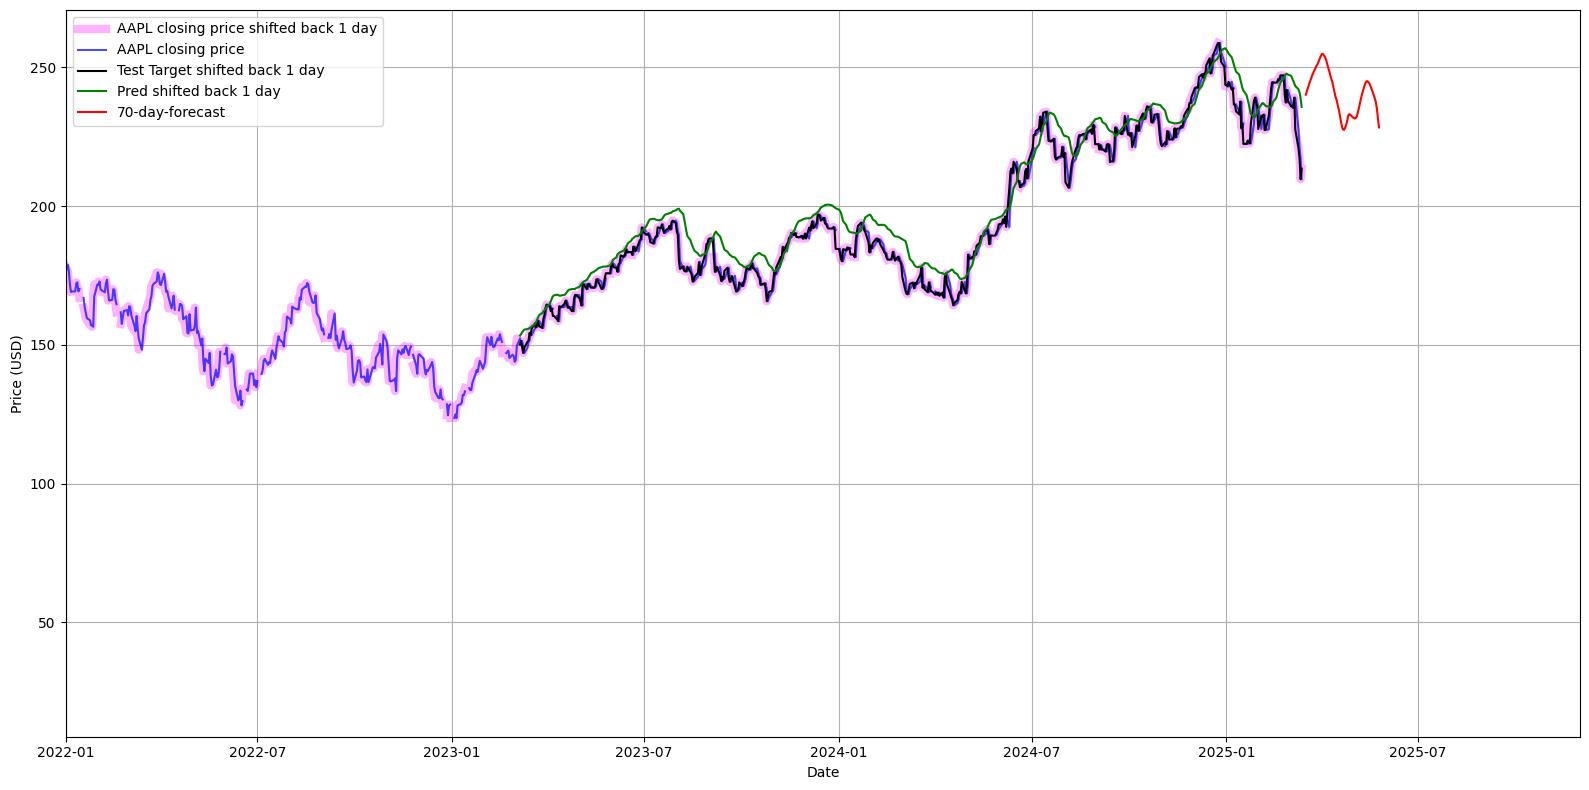

In [43]:
# Fetching the latest 100 days of AAPL stock data

num_of_months = 4

# Getting latest stock data from past num_of_monhs specified
closing_prices = yf.download(chosen_stock, period=f'{num_of_months}mo', interval='1d', multi_level_index = False)

# Creating our Target variable e.g., Close price of current date shifted back one day
closing_prices['TargetNextClose'] = closing_prices['Close'].shift(-1)

# Trimming off last record with NaN value for TargetNextDayClose
closing_prices = closing_prices[:-1]

closing_prices.index = pd.to_datetime(closing_prices.index)

# Ensuring our dates are business days frequency
closing_prices = closing_prices.asfreq('B')

# Forward-Fill any missing values 
for col in closing_prices.columns:

    closing_prices[col] = closing_prices[col].ffill()

# Scaling the Latest data
X_latest = mms.fit_transform(closing_prices[x_col])

X_latest = pd.DataFrame(X_latest, columns=x_col, index=closing_prices.index)

y_latest = mms.fit_transform(closing_prices[target_col])

y_latest = pd.DataFrame(y_latest, columns=target_col,  index=closing_prices.index)

df_stock_data_latest = pd.concat([X_latest, y_latest], axis=1)

# Since we need the last <LOOK_BACK> days to predict the next day, we reshape the data accordingly
X_latest_arr = np.array(df_stock_data_latest)

X_latest =[]
for i in range(LOOK_BACK, len(X_latest_arr)):
    X_latest.append(X_latest_arr[i-LOOK_BACK:i,:len(df_stock_data_latest.columns)])

X_latest = np.array(X_latest)
print("Input Latest forecasting data Shape Verification ...")
print(X_latest.shape)

## Making predictions for the next days
predicted_stock_price = model.predict(X_latest)
predicted_stock_price = mms.inverse_transform(predicted_stock_price)

# Creating new DataFrame with future dates
days_index = [ pd.to_datetime(st) + pd.offsets.Day(i) for i in range(len(predicted_stock_price))]

df_pred_days = pd.DataFrame(predicted_stock_price, columns=['predicted'] , index=days_index)
df_pred_days.index.name = 'Date'

print(f"Predicted Stock Prices from past {num_of_months} Months to forecast {len(predicted_stock_price)} days: ")


# Plotting results
plt.figure(figsize=(16,8))

# Line plot of the APPL stock data shifted back one day
plt.plot(appl_stock_data['TargetNextClose'], label=f"{chosen_stock} closing price shifted back 1 day", color="magenta", lw=6, alpha=0.3)

# Line plot of the APPL stock data
plt.plot(appl_stock_data['Close'], label=f"{chosen_stock} closing price", color="blue", alpha=0.7)

plt.plot(y_test_trn, color = 'black', label = 'Test Target shifted back 1 day')
plt.plot(y_pred_trn, color = 'green', label = 'Pred shifted back 1 day')

plt.plot(df_pred_days, color = 'red', label = f'{len(predicted_stock_price)}-day-forecast')

plt.xlim(pd.to_datetime('2022-01-01'))

plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.tight_layout()
plt.grid(True)
plt.show()

### Observation
- We specified to look back at 4 months worth of stock data, to forecast the next 70 business days (Red-Line).
- We can see the prediction by the Deep Learning model tends to follow the **Multiplicative** time series, as the fluctuations increases as the trend increases.

---
# 3. Model Comparisons

- Here, we will be comparing the models below:

| **Method** | **Quick Description** | **Pros** | **Cons** |
| --- | --- | --- | --- |
| **ARIMA (AutoRegressive Integrated Moving Average)** | A model that combines autoregressive, differencing, and moving average components to handle stationary time series data. | Can model complex relationships;  Flexible and widely used;  Handles various patterns well | Assumes stationarity (data needs to be transformed); Requires careful parameter tuning |
| **Deep Learning Based** | Uses advanced neural network architectures (e.g., LSTM, RNN) to capture complex patterns and dependencies in time series data. | Can model complex patterns and nonlinear relationships;  Effective for long-term forecasting;  Handles multiple variables | Computationally intensive;  Requires large datasets;  Complex to implement and interpret |
| **Prophet** | A forecasting tool by Facebook that uses additive or multiplicative models to handle trends, seasonality, and holidays. | Handles missing data and outliers well;  Simple to use and interpret;  Includes holiday effects and seasonality | Less effective with highly irregular data; Assumes a specific trend model |

## 3.1 ARIMA Model Implementation

**ARIMA (AutoRegressive Integrated Moving Average)** models are popular for forecasting stationary time series. 

While exponential smoothing models are based on a description of the trend and seasonality in the data, ARIMA models aim to describe the autocorrelations in the data.

### What is Autocorrelation?

-   **Definition:** Autocorrelation is the correlation of a time series with its own past values. It shows how current values of a series relate to past values at different time lags.
-   **Lag:** A lag is the time difference between observations. For example, a lag of 1 means comparing each value with the value from the previous time period.

**So what?**
Autocorrelation helps in identifying patterns within a time series data, such as seasonality or cyclic behavior. This information is essential for selecting appropriate models and making accurate predictions.


### When to Use ARIMA:
-   **Stationarity:** ARIMA models assume that the data is stationary. If autocorrelation patterns suggest trends or seasonality, you may need to transform the data (e.g., differencing) to meet this assumption. More on stationarity [here](https://otexts.com/fpp3/stationarity.html).

-   **Autocorrelation:** If your time series data shows significant autocorrelation, it suggests that past values can help predict future values, making ARIMA a suitable model.

**ARIMA Components:**
-   **AR (AutoRegressive):** Uses the relationship between an observation and a number of lagged observations.
-   **I (Integrated):** Represents differencing of raw observations to make the time series stationary.
-   **MA (Moving Average):** Uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.


---
### Plotting and interpreting autocorrelation, for past 30 days of chosen stock data

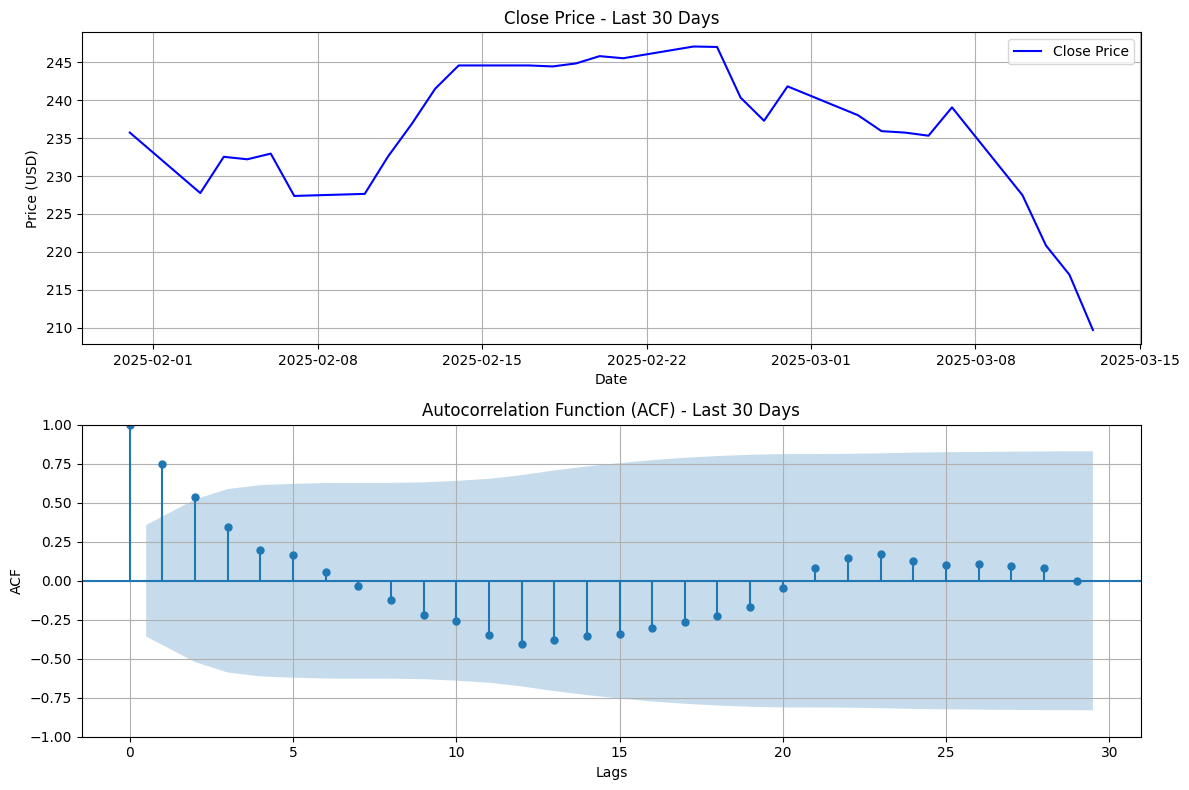

In [16]:
from statsmodels.graphics.tsaplots import plot_acf

# Filter the stock data for the last 30 days
last_30_days = appl_stock_data_ffil.tail(30)["Close"]

# Create a figure with subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot the time series
ax1.plot(last_30_days.index, last_30_days, label='Close Price', color='blue')
ax1.set_title('Close Price - Last 30 Days')
ax1.set_xlabel('Date')
ax1.set_ylabel('Price (USD)')
ax1.legend()
ax1.grid()

# Plot the autocorrelation
plot_acf(last_30_days, lags=29, ax=ax2)
ax2.set_title('Autocorrelation Function (ACF) - Last 30 Days')
ax2.set_xlabel('Lags')
ax2.set_ylabel('ACF')
ax2.grid()

# Adjust layout
plt.tight_layout()
plt.show()

### Observation
- The Auto Correlation Forecasting (ACF) plots shows there are some coreelations of the time series with its own past values (lags)
- The **x-axis** represents the lag (how many time periods back you're correlating the current value with), and the **y-axis** shows the correlation coefficient.

- **Positive Correlations**:
    - Found between Lag 0-6 and 21-30 days, no significant spikes

- **Negative Correlations** (mean-reverting behaviors):
    - Found between Lag 7- 20 days, no significant spikes

- There seems to be a slow decay pattern, indicating non-stationary process/
- Cyclic pattern fluctuation from positive to negative correlations; would require full stock data to confirm this, to detect any repetitions periodically, indicative of a cycle or seasonality. This means that the time series might have regular ups and downs at predictable intervals, with a cycle length roughly equal to the total number of lags showing this pattern.

- Overview, There are no signs of any cyclcal influence, it only has a high-confidence correlation lag at 1 day, may indicate large amounts of noise, with other factors influencing the stock price.


### Building an ARIMA model for forecasting

Admittedly, interpreting the above Autocorrelation graph can be very hard!

Luckily, we have 2 options to build an ARIMA model:
- **Option 1 (simpler approach)**:  leverage a python library to automatically build the optimal ARIMA model. 
- **Option 2 (harder approach)**:  set up your model manually, based on interpretation of ACF plots (as well as stationarity tests and partial autocorrelation plot).
    - Option 2, see step by step guide [here (also linked above)](https://mlpills.dev/time-series/parameters-selection-in-arima-models/).

We will follow Option 1.   

In [17]:
### Define our train test split using test size = number of business days to forecast

# Building train test data for TimeSeries forecasting, to utilise for other models
def train_test_split_temporal(data, test_size):
    train = data[:-test_size]
    test = data[-test_size:]
    return train, test



Series is non-stationary --> d > 1
Series is non-stationary --> d > 1




c:\Users\cpitt\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cpitt\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cpitt\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cpitt\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\cpitt\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be rem

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 2540
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -5192.025
Date:                Mon, 17 Mar 2025   AIC                          10388.051
Time:                        23:42:40   BIC                          10399.730
Sample:                    01-02-2015   HQIC                         10392.287
                         - 09-26-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0798      0.037      2.150      0.032       0.007       0.153
sigma2         3.4971      0.046     75.373      0.000       3.406       3.588
===================================================================================
Ljung-Box (L1) (Q):                   1.12   Jarque-Bera (JB):              5127.71
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):              42.37   Skew:                             0.10
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

c:\Users\cpitt\anaconda3\envs\tf\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


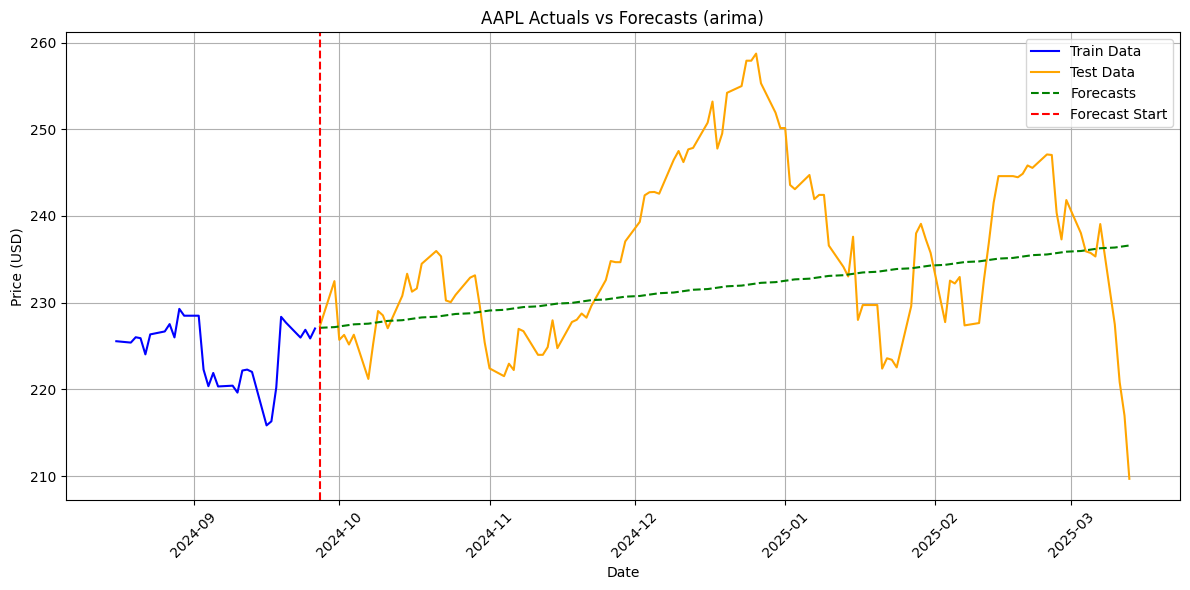

Mean Absolute Error (MAE): 7.70
Root Mean Squared Error (RMSE): 10.19

 ... Evaluation Metrics for Regression ... 
MAE: 7.703520954408172
MSE: 103.82417772207937
RMSE: 10.189414984290284
R-squared: -0.07061511892746575


In [18]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Filter the stock data for the last X days

x_days = 120

last_x_days = appl_stock_data_ffil.tail(x_days)["Close"]

# First, let's check if series is stationary
from statsmodels.tsa.stattools import adfuller

pvalue = adfuller(last_x_days)[1]
if pvalue < 0.05:
    print('Series is stationary --> d = 1')
else:
    print('Series is non-stationary --> d > 1')

pvalue = adfuller(appl_stock_data_ffil["Close"])[1]
if pvalue < 0.05:
    print('Series is stationary --> d = 1')
else:
    print('Series is non-stationary --> d > 1')

print("\n")

from pmdarima.arima import auto_arima

train_data, test_data = train_test_split_temporal(appl_stock_data_ffil['Close'], x_days)

model_auto = auto_arima(train_data, max_p=11, max_d=2, max_q=11)

display(model_auto.summary())

def plot_actuals_vs_forecasts(train_data, test_data, forecasts, title='Actuals vs Forecasts'):
    """
    Plot actual values against forecasted values and print error metrics.

    Parameters:
    train_data (pd.Series): Training values.
    test_data (pd.Series): Testing values.
    forecasts (pd.Series): Forecasted values.
    title (str): Title of the plot.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data, label='Train Data', color='blue')
    plt.plot(test_data.index, test_data, label='Test Data', color='orange')
    plt.plot(forecasts.index, forecasts, label='Forecasts', color='green', linestyle='--')
    plt.axvline(x=test_data.index[0], color='red', linestyle='--', label='Forecast Start')
    plt.legend(loc='best')
    plt.title(title)
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    # Calculate and print error metrics
    mae = mean_absolute_error(test_data, forecasts)
    rmse = np.sqrt(mean_squared_error(test_data, forecasts))
    
    print(f'Mean Absolute Error (MAE): {mae:.2f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

arima = model_auto.predict(len(test_data))

plot_actuals_vs_forecasts(train_data.tail(30)
                          , test_data
                          , arima
                          , title=f'{chosen_stock} Actuals vs Forecasts (arima)')

model_evaluation_report_regression(test_data, arima)


### Observation
SARIMAX(0, 1, 0) is a form of the SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables) model.

SARIMAX(**p**, **d**, **q**) Explained below;

#### **Components**:

**p (AutoRegressive order)**  
    -   The AR term specifies how many past observations (lags) are used to predict the current observation.  
    -   In **(0, 1, 0)**, p = 0, meaning **no autoregressive terms** are included. The model does not use past values to directly predict future values.  

**d (Differencing order)**  
    -   The differencing term tells us how many times we need to difference the time series to make it stationary. Differencing is used to remove trends or seasonality.  
    -   In **(0, 1, 0)**, d = 1, meaning the model applies **first-order differencing**. In simple terms, this means the model uses the **change** between consecutive observations (i.e., the difference between the current value and the previous value) to make predictions.  
    -   Differencing helps stabilize the time series by removing any trends, making it easier to model.
 
**q (Moving Average order)**  
-   The MA term controls how many past forecast errors are used to predict the current observation.  
-   In **(0, 1, 0)**, q = 0, meaning **no moving average terms** are included. The model does not use past forecast errors to make predictions.  

**IN SUMMARY**: This model essentially assumes that future values are a function of their previous value plus a constant drift (if any), without relying on past values or errors.

This model is useful when your time series shows a random walk-like behavior with no significant autocorrelation structure but possibly a trend. Stock prices or financial metrics that fluctuate randomly but increase or decrease over time are an example for this.  

- **No Seasonal Parameters**: The absence of seasonal orders (P, D, Q, and s) in the model specification strongly suggests that auto_arima did not find statistically significant seasonality in your training data.

- **Simple Model**: The selected model (0, 1, 0) is a very simple ARIMA model, essentially just a differenced random walk. This often happens when there is very little to no seasonality, or a very weak seasonality.
- it makes sense that auto_arima might not find seasonality in Apple stock data, due to lack of fixed seasonal parameters.

### Final Note:

- The model evaluation results are;
    - Mean Absolute Error (MAE): 7.70
    - Root Mean Squared Error (RMSE): 10.19

- Hence, an error tolerance between 7-10 $

### 3.2 Prophet Model Implementation

*"Prophet is a forecasting procedure implemented in R and Python. It is fast and provides completely automated forecasts that can be tuned by hand by data scientists and analysts."*
Documentation found [here](https://facebook.github.io/prophet/)

- Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. It works best with time series that have strong seasonal effects and several seasons of historical data. Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.

#### Other factors of Prophet
**Accurate and fast**
- Prophet is used in many applications across Facebook for producing reliable forecasts for planning and goal setting. We’ve found it to perform better than any other approach in the majority of cases. We fit models in [Stan](http://mc-stan.org/) so that you get forecasts in just a few seconds.

- [Stan](http://mc-stan.org/) Stan: Software for Bayesian Data Analysis
    - Bayesian Modeling
        Stan enables sophisticated statistical modeling using Bayesian inference, allowing for more accurate and interpretable results in complex data scenarios.

    - Flexible and Scalable
        Stan’s probabilistic programming language is suitable for a wide range of applications, from simple linear regression to multi-level models and time-series analysis.

    - Multi-Language, Cross-Platform Toolkit
        Interfaces for Python, Julia, R, and the Unix shell make it easy to use Stan in any programming environment, on laptops, clusters, or in the cloud. A rich ecosystem of tools for validation and visualization support decision-making and communication


In [19]:
# Import Facebook prophet

from prophet import Prophet

### 3.2.1 Univariate Model
- Creating a prophet model by just using date index and target feature 'Close'

23:44:50 - cmdstanpy - INFO - Chain [1] start processing
23:44:50 - cmdstanpy - INFO - Chain [1] done processing


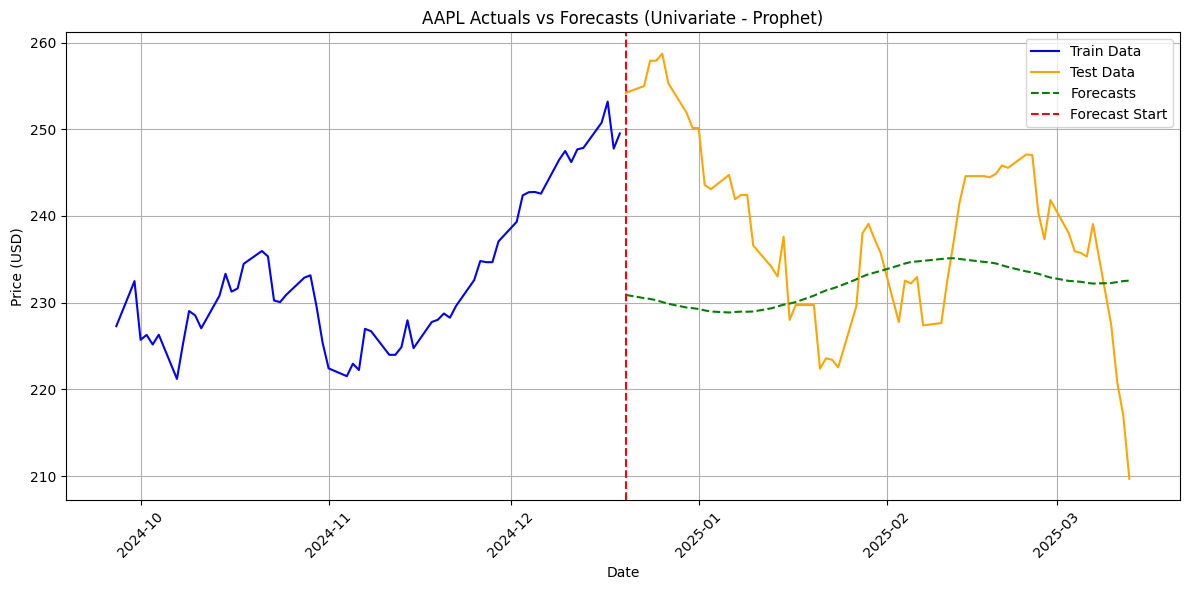

Mean Absolute Error (MAE): 10.19
Root Mean Squared Error (RMSE): 12.68

 ... Number of future days forecast : 33


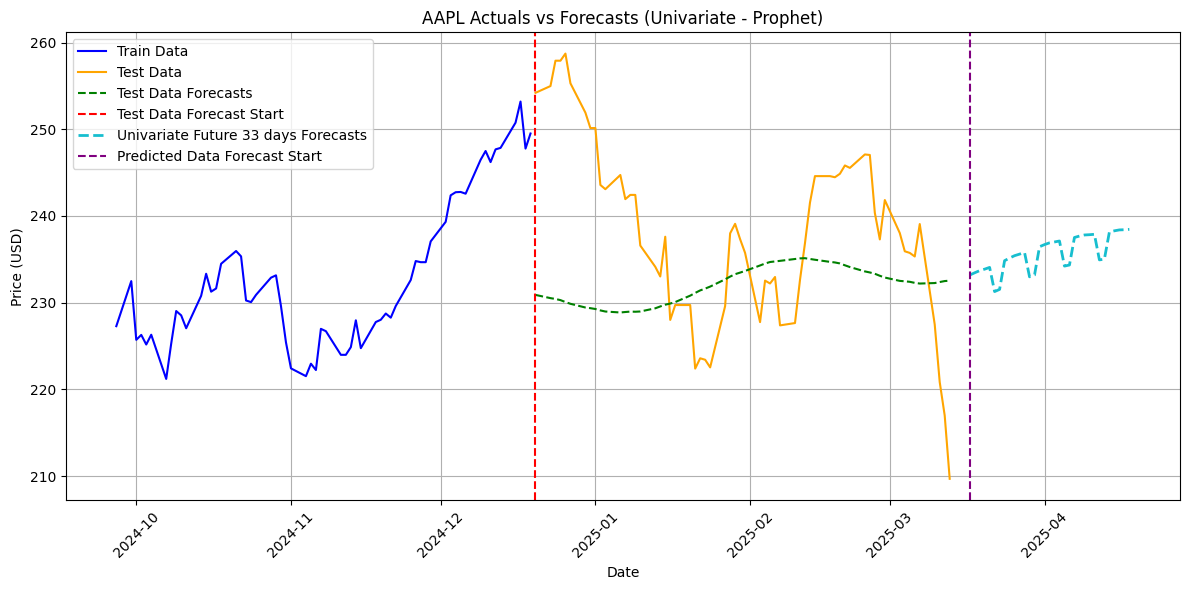


 ... Evaluation Metrics for Regression ... 
MAE: 10.193153045339491
MSE: 160.84103801703628
RMSE: 12.682312013865465
R-squared: -0.4662847067295828


In [28]:
# Initialize Prophet model
prophet_model = Prophet(scaling="minmax")

# Train test of 60 days
x_days = 60

target_col_pht = 'Close'

train_data_pht, test_data_pht = train_test_split_temporal(appl_stock_data_ffil[target_col_pht], x_days)

# Fit the model
train_df = pd.DataFrame(train_data_pht).reset_index().rename(columns={'Date':'ds', target_col_pht:'y'})

# Fitting the model
prophet_model.fit(train_df)

# Generate forecast on test set
test_df = pd.DataFrame(test_data_pht).reset_index().rename(columns={'Date':'ds', target_col_pht:'y'})

# Making predictions on Test Data
prophet = prophet_model.predict(test_df)

#display(prophet.head())

type(prophet[['ds','yhat']]), type(test_data_pht)

t = prophet[['ds','yhat']]

train_df.set_index('ds', inplace=True)
test_df.set_index('ds', inplace=True)
t.set_index('ds', inplace=True)

plot_actuals_vs_forecasts(train_df['y'].tail(60)
                          , test_df['y'].tail(60)
                          , t[['yhat']]
                          , title=f'{chosen_stock} Actuals vs Forecasts (Univariate - Prophet)')

# Make future dataframe

# The Prophet model is trained on x_days, for us to forecast/predict the closing price for the next X days
# it will be future_days_to_forecast = initial (x_days) + future_days to forecast on

future_days = 60 # days

future_days_to_forecast = x_days + future_days

future = prophet_model.make_future_dataframe(periods=future_days_to_forecast, freq = "D", include_history=True)

# Predict the future values
forecast = prophet_model.predict(future)

t_future = forecast[['ds','yhat']]

t_future = t_future[t_future['ds'] >= st ]

print(f"\n ... Number of future days forecast : {len(t_future)}")

t_future.set_index('ds', inplace=True)

plt.figure(figsize=(12, 6))
plt.plot(train_df.tail(60).index, train_df['y'].tail(60), label='Train Data', color='blue')

plt.plot(test_df.index, test_df['y'], label='Test Data', color='orange')

plt.plot(t.index, t[['yhat']], label='Test Data Forecasts', color='green', linestyle='--')
plt.axvline(x=t.index[0], color='red', linestyle='--', label='Test Data Forecast Start')

plt.plot(t_future.index, t_future[['yhat']], label=f'Univariate Future {len(t_future)} days Forecasts', color='tab:cyan', linestyle='--' , lw=2.)

plt.axvline(x=t_future.index[0], color='purple', linestyle='--', label='Predicted Data Forecast Start')
plt.legend(loc='best')
plt.title(f'{chosen_stock} Actuals vs Forecasts (Univariate - Prophet)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()

model_evaluation_report_regression(test_df['y'], t[['yhat']])

### Observation
- The Univariate Prophet model is easily implemented to begin to make forecasted predictions.

### Final Note:

- The model evaluation results are;
    - Mean Absolute Error (MAE): 10.15
    - Root Mean Squared Error (RMSE): 12.64

- Hence, an error tolerance between 10-12 $



### 3.2.2 Multivariate model
- Using multiple input features and target feature 'Close'

23:42:43 - cmdstanpy - INFO - Chain [1] start processing
23:42:44 - cmdstanpy - INFO - Chain [1] done processing


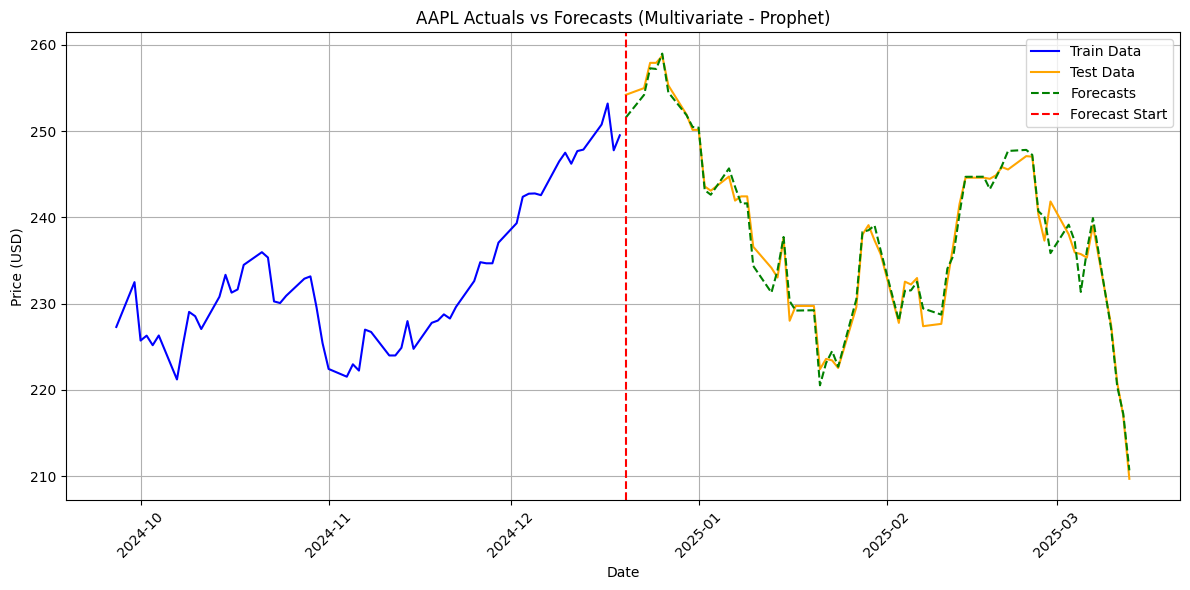

Mean Absolute Error (MAE): 1.04
Root Mean Squared Error (RMSE): 1.48

 ... Evaluation Metrics for Regression ... 
MAE: 1.0403793250862041
MSE: 2.1823617004008424
RMSE: 1.4772818622053283
R-squared: 0.9801048064268822


In [21]:
# Initialize Prophet model
prophet_model_2 = Prophet(scaling="minmax")

# to Remove the 'TargetNextClose' target feature(s)
x_col_pht = [col for col in appl_stock_data_ffil.columns if r'Close' not in col]

# Train test of 60 days
x_days = 60

target_col_pht = 'Close'

train_data_pht_2, test_data_pht_2 = train_test_split_temporal(appl_stock_data_ffil[x_col_pht + [target_col_pht]], x_days)

# Fit the model
train_df_2 = pd.DataFrame(train_data_pht_2).reset_index().rename(columns={'Date':'ds', target_col_pht:'y'})

# Adding multiple features to the model as regressors
for input_cols in x_col_pht:
    prophet_model_2.add_regressor(input_cols, standardize=True)

# Fitting the model
prophet_model_2.fit(train_df_2)

# Generate forecast on test set
test_df_2 = pd.DataFrame(test_data_pht_2).reset_index().rename(columns={'Date':'ds', target_col_pht:'y'})

# Making predictions on test data
prophet_2 = prophet_model_2.predict(test_df_2)

type(prophet_2[['ds','yhat']]), type(test_data_pht_2)

t_2 = prophet_2[['ds','yhat']]

train_df_2.set_index('ds', inplace=True)
test_df_2.set_index('ds', inplace=True)

t_2.set_index('ds', inplace=True)

plot_actuals_vs_forecasts(train_df_2['y'].tail(x_days)
                          , test_df_2['y']
                          , t_2[['yhat']].tail(x_days)
                          , title=f'{chosen_stock} Actuals vs Forecasts (Multivariate - Prophet)')


model_evaluation_report_regression(test_df_2['y'], t_2[['yhat']])

23:42:45 - cmdstanpy - INFO - Chain [1] start processing
23:42:45 - cmdstanpy - INFO - Chain [1] done processing
23:42:46 - cmdstanpy - INFO - Chain [1] start processing
23:42:46 - cmdstanpy - INFO - Chain [1] done processing
23:42:47 - cmdstanpy - INFO - Chain [1] start processing
23:42:48 - cmdstanpy - INFO - Chain [1] done processing
23:42:48 - cmdstanpy - INFO - Chain [1] start processing
23:42:48 - cmdstanpy - INFO - Chain [1] done processing
23:42:49 - cmdstanpy - INFO - Chain [1] start processing
23:42:50 - cmdstanpy - INFO - Chain [1] done processing


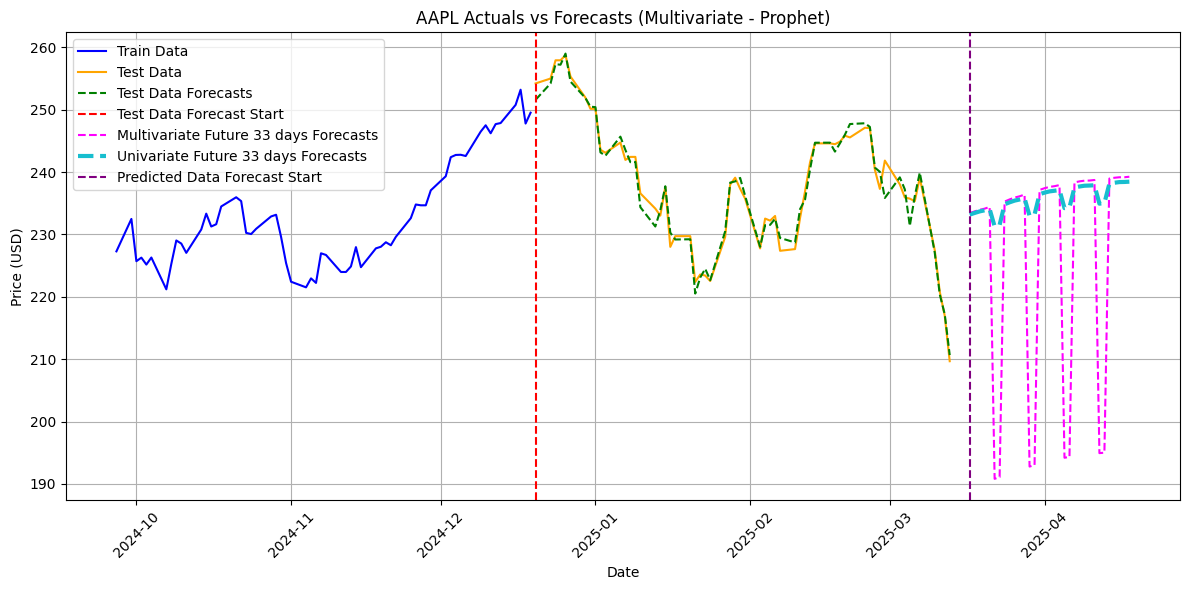

In [22]:
# Make future dataframe

# The Prophet model is trained on x_days, for us to forecast/predict the closing price for the next X days
# it will be future_days_to_forecast = initial (x_days) + future_days to forecast on

future_days = 60 # days

future_days_to_forecast = x_days + future_days

df_future_dates = prophet_model_2.make_future_dataframe(periods=future_days_to_forecast, freq='D', include_history=True)

df_future_dates = df_future_dates[(df_future_dates['ds'] >= st)]

df_future_dates.set_index('ds' , inplace=True)

df_future_dates = pd.concat([train_df_2, test_df_2, df_future_dates], axis=0)

#display(df_future_dates)

df_train_test = df_future_dates[(pd.isnull(df_future_dates['y'])==False)
                         &
                         (df_future_dates.index < st)]

future = df_future_dates[(df_future_dates.index >= st)]

df_list = []

pred_cols = future.columns  #x_col_pht #+ [target_col_pht]

# Using Prophet to train and make predictions on the additional input features
for col in pred_cols: #x_col:

    train = pd.DataFrame(df_train_test[col]).reset_index().rename(columns={'Date':'ds', col:'y'})

    prophet = Prophet(scaling="minmax")

    sub_prophet = prophet.fit(train)

    df_future_days = future[col].reset_index().rename(columns={'Date':'ds', col:'y'})
    
    df_future_days_pred = sub_prophet.predict(df_future_days)[['ds','yhat']]

    df_future_days_pred.set_index('ds', inplace=True)

    df_future_days_pred = df_future_days_pred.rename(columns={'yhat': col})

    df_list.append(df_future_days_pred)

df_future_var_pred = pd.concat(df_list, axis=1).reset_index()

df_future_var_pred = prophet_model_2.predict(df_future_var_pred)

df_future_var_pred = df_future_var_pred[['ds'] + x_col_pht + ['yhat']]
df_future_var_pred.set_index('ds', inplace=True)


plt.figure(figsize=(12, 6))
plt.plot(train_df_2.tail(60).index, train_df_2['y'].tail(60), label='Train Data', color='blue')

plt.plot(test_df_2.index, test_df_2['y'], label='Test Data', color='orange')

plt.plot(t_2.index, t_2[['yhat']], label='Test Data Forecasts', color='green', linestyle='--')
plt.axvline(x=t_2.index[0], color='red', linestyle='--', label='Test Data Forecast Start')

plt.plot(df_future_var_pred.index, df_future_var_pred[['yhat']], label=f'Multivariate Future {len(df_future_var_pred)} days Forecasts', color='magenta', linestyle='--')

plt.plot(t_future.index, t_future[['yhat']], label=f'Univariate Future {len(t_future)} days Forecasts', color='tab:cyan', linestyle='--' , lw=3.)

plt.axvline(x=df_future_var_pred.index[0], color='purple', linestyle='--', label='Predicted Data Forecast Start')
plt.legend(loc='best')
plt.title(f'{chosen_stock} Actuals vs Forecasts (Multivariate - Prophet)')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


### Observation
- The Multivariate Prophet model is easily implemented to begin to make forecasted predictions.
- However, the challenges come into play when we begin to use multiple features.
- For future feature predictions will require a whle other set of modelling for each one, before implementing into a multivariate model.
- When compared to the Univariate model, the Univariate model provides better predictions based on a 'smaller' predicted range

### Final Note:

- The model evaluation results are;
    - Mean Absolute Error (MAE): 1.04
    - Root Mean Squared Error (RMSE): 1.48

- Hence, an error tolerance between 1-1.5 $

### Additional Feature via Prophet
- Here, we utilise the Univariate prophet model

- To plot its components, to identify trends (top 3 Plots)

- To plot the forecasting model itself (Bottom Timeseries Plot)
    - The black points represent the data points used to train the model
    - The blue line represents the forecast
    - The light blue area represents the confidence intervals.

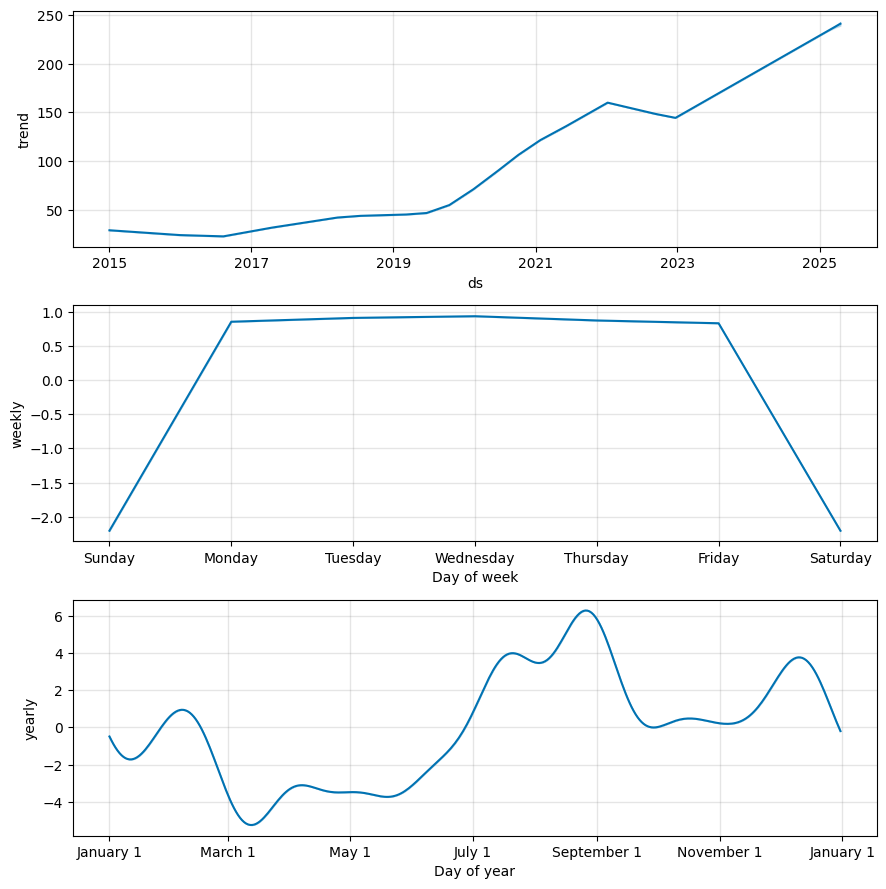

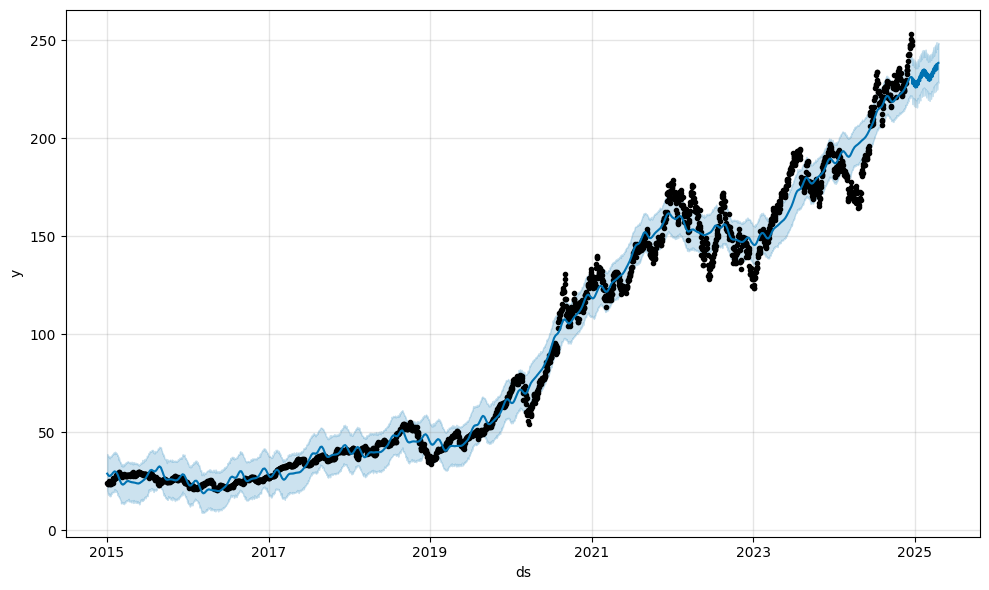

In [29]:
prophet_to_plot = prophet_model.predict(future.reset_index())

# Plot the components of the model
fig = prophet_model.plot_components(prophet_to_plot)

fig2 = prophet_model.plot(prophet_to_plot)


### Observation
- We see throughout the year, there is a noticable spike durng September.
- From 2022 to 2023, there was a slight decline, but then the trend shot back up again

# 3.3 Models Comparisons

## **RECAP**

| **Method** | **Quick Description** | **Pros** | **Cons** |
| --- | --- | --- | --- |
| **ARIMA (AutoRegressive Integrated Moving Average)** | A model that combines autoregressive, differencing, and moving average components to handle stationary time series data. | Can model complex relationships;  Flexible and widely used;  Handles various patterns well | Assumes stationarity (data needs to be transformed); Requires careful parameter tuning |
| **Deep Learning Based** | Uses advanced neural network architectures (e.g., LSTM, RNN) to capture complex patterns and dependencies in time series data. | Can model complex patterns and nonlinear relationships;  Effective for long-term forecasting;  Handles multiple variables | Computationally intensive;  Requires large datasets;  Complex to implement and interpret |
| **Prophet** | A forecasting tool by Facebook that uses additive or multiplicative models to handle trends, seasonality, and holidays. | Handles missing data and outliers well;  Simple to use and interpret;  Includes holiday effects and seasonality | Less effective with highly irregular data; Assumes a specific trend model |

---

## Model Evaluations

| **Method** | **Mean Absolute Error (MAE)** | **Root Mean Squared Error (RMSE)** | **Mean Squared Error (MSE)** | **R^2 score** |
| --- | --- | --- | --- |--- |
| **Deep Learning Based (LSTM)** | 0.025 | 0.032 | 0.001 | 0.92 |
| **ARIMA (AutoRegressive Integrated Moving Average)** | 7.7 | 10.2 | 103.8 | -0.07 |
| **Prophet (Univariate)** | 10.2 | 12.7 | 161.54 | -0.47 |
| **Prophet (Multivariate)** | 1.04 | 1.5 | 2.1 | 0.98 |

## Conclusion:
We can see, overall the Deep Learning model performs the best. However, it requires a lot of work to construct, finetune...etc, and to set-up the dataset to read, and computationally expensive; hece it becomes quite challenging pogrammatically and interpretability.
As for the Other models, Prophet (Multivariate) comes in second, followed by the Prophet (Univariate) and ARIMA. Despite their simplicity to implement, they do require a lot of research, investigation and modelling/parameter fine tuning to get good results.

---
# 4. Business Trading Insights

As a Business/Trading firm that want to utilise Deep Learing models for their trading algorithms comes with many implications such as;
1. They are computationally expensive
2. They are complex models that can lead to overfiiting and challenging to interpret.
3. they do require finetuning, which becomes quite time consuming
4. Highly dependant on large amounts of data to train on.

Although these may seem daunting, there are some advantages where Deep Learning models can provide incredible value such as;
1. Automatic feaure learning, and using mutiple features into a model that can influence predictions, unlike other models such as ARIMA can only perform on just historical price and seasonal trends.
2. Since they require large amounts of data, it makes them highly scalable
3. Handle structured and non-structred data, in addition to non-linear relationships within large complex datasets (which can be quite difficult via tradional methods)
4. Handling sequential data, Deep learning algorithms such as Recurrent Neural Networks (RNNs) and Long Short-term Memory (LSTM) networks are particularly suited to handle sequential data such as time series. These algorithms have the ability to maintain context and memory over time, which allows them to make predictions or decisions based on past inputs with the additional of multiple features.

---
# 5. Experiementation with Architecture, Hyperparameter tuning & Additional features (Optional)

- **Bi-LSTM: (bidirectional long-term short-term memory)**:
Bidirectional LSTMs (Bi-LSTMs) enhance traditional LSTM models by integrating input information from both past and future time steps. They achieve this by combining two independent RNNs. This architecture allows the network to leverage both preceding and succeeding contexts at each time step, thereby enhancing accuracy. It’s akin to predicting the middle words of a sentence by knowing both its first and last words.

In Bi-LSTMs, inputs are processed in two directions: one from past to future and another from future to past. This bidirectional approach differs from unidirectional LSTM, where information flows only in one direction (typically forward). By incorporating both forward and backward hidden states, Bi-LSTMs maintain a comprehensive view of both past and future information throughout the sequence.
---
Source: [timeseries_prediction_LSTM_BiLSTM](https://medium.com/data-science-data-engineering/time-series-prediction-lstm-bi-lstm-gru-99334fc16d75)

In [46]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense ,Dropout, Bidirectional
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# Initialise scaling
mms = MinMaxScaler(feature_range=(0,1))

# Define are target feature i.e., Close price
target_col = ['TargetNextClose']

# Define our inut features i.e., open, volumne, ...etc
x_col = [col for col in appl_stock_data_ffil.columns if col != target_col[0]]

# Transform the input features
X_mms = mms.fit_transform(appl_stock_data_ffil[x_col])

# Transformed input features into Dataframe --- Just for clarity to ensure our data has properly been transformed
X_mms = pd.DataFrame(X_mms, columns=x_col, index=appl_stock_data_ffil.index)

# Transform target feature
y_mms = mms.fit_transform(appl_stock_data_ffil[target_col])

# Transformed target feature into Dataframe --- Just for clarity to ensure our data has properly been transformed 
# Also, this will help us inverse_tranform our predicted values back to real values
y_mms = pd.DataFrame(y_mms, columns=target_col,  index=appl_stock_data_ffil.index)

# DataFrame of the transformed features
df_stock_data_mms = pd.concat([X_mms, y_mms], axis=1)

display(df_stock_data_mms)

stock_data_mms = np.array(df_stock_data_mms)

# initialize empty list to hold input features
X = []

# To capture time-based trends, we organize the data into sequences of <LOOK_BACK> days, which the LSTM model can then learn from.
# Setting the number of previous time-steps to consider for each sample
LOOK_BACK = 15 # days

# Loop through each input feature, with chuncks of arrays in slices of <LOOK_BACK> 
# This converts the input features into array shape (num_of_records, LOOK_BACK, num_of_columns )
for i in range(LOOK_BACK, len(stock_data_mms)):
    X.append(stock_data_mms[i-LOOK_BACK:i,:len(appl_stock_data_ffil.columns)])

# Taking the Target feature from our scaled array
y = np.array(stock_data_mms[LOOK_BACK:,-1])

# shape (num_of_records, LOOK_BACK, num_of_columns )
y = np.reshape(y,(len(y),1))

# SPlit data in train : test ~ 80%
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train, y_train = np.array(X_train), np.array(y_train)

X_test, y_test = np.array(X_test), np.array(y_test)

# Shape Verification:
print("\n Shape verification ")
print(f"X_train Shape == {X_train.shape}")
print(f"X_test Shape = {X_test.shape}")
print(f"y_train Shape = {y_train.shape}")
print(f"y_test Shape = {y_test.shape}")


# Building the Bi-LSTM model

def bi_lstm_model(X_trainn, y_trainn, neurons, epochs, batch_size):
    
    # Define Architecture
    #model = Sequential() 
    bi_lstm_input = Input(shape=(X_train.shape[1], X_train.shape[2]), name='lstm_bi_lstm_inputinput')

    # define input shape and layer 
    inputs = Bidirectional(LSTM(neurons*2, name='first_layer',return_sequences=True, activation='relu'))(bi_lstm_input)

    # Second input layer
    inputs = Bidirectional(LSTM(neurons, name='second_layer',return_sequences=True, activation='relu'))(inputs)

    # Third input layer
    inputs = Bidirectional(LSTM(int(neurons*0.5), name='third_layer',return_sequences=False, activation='relu'))(inputs)

    # Output layer 
    inputs = Dense(1, name='dense_layer')(inputs)
    output = Activation('linear', name='output')(inputs)
    model = Model(inputs=bi_lstm_input, outputs=output)

    # Compiling model
    model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])

    # Early stop to avoid overfit
    early_stop = EarlyStopping(
        monitor='val_loss',  # Evaluation metric to watch 
        mode='max',
        patience=10,               # Stop if no improvement after <X> epochs
        restore_best_weights=True  # Restore the model weights at the best epoch
    )

    history = model.fit(X_trainn, y_trainn, 
                        epochs = epochs, 
                        validation_split = 0.2,
                        batch_size = batch_size, 
                        shuffle = True, 
                        callbacks = [early_stop],
                        verbose=0)
    

    return history


,Close,High,Low,Open,Volume,TargetNextClose
Date,,,,,,
2015-01-02,0.015315,0.015956,0.014373,0.017622,0.303048,0.012437
2015-01-05,0.012437,0.013358,0.012551,0.014716,0.373898,0.012446
2015-01-06,0.012446,0.012221,0.011819,0.013076,0.383564,0.013839
2015-01-07,0.013839,0.012938,0.013763,0.013695,0.219295,0.017707
2015-01-08,0.017707,0.016617,0.015641,0.015598,0.342434,0.017819
...,...,...,...,...,...,...
2025-03-07,0.917393,0.922774,0.904644,0.903938,0.036827,0.868708
2025-03-10,0.868708,0.900960,0.860148,0.905750,0.078065,0.840816
2025-03-11,0.840816,0.857750,0.831567,0.856321,0.084564,0.824602



 Shape verification 
X_train Shape == (2116, 15, 6)
X_test Shape = (529, 15, 6)
y_train Shape = (2116, 1)
y_test Shape = (529, 1)


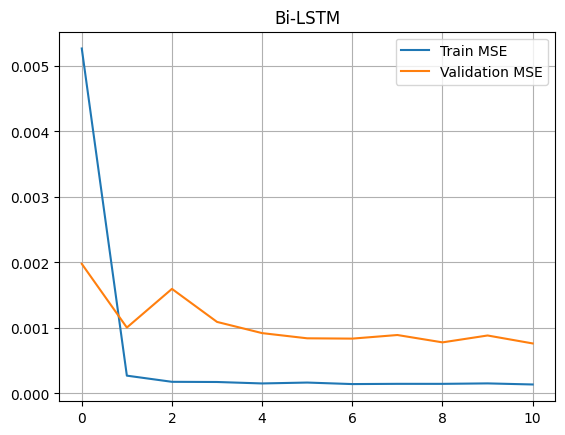

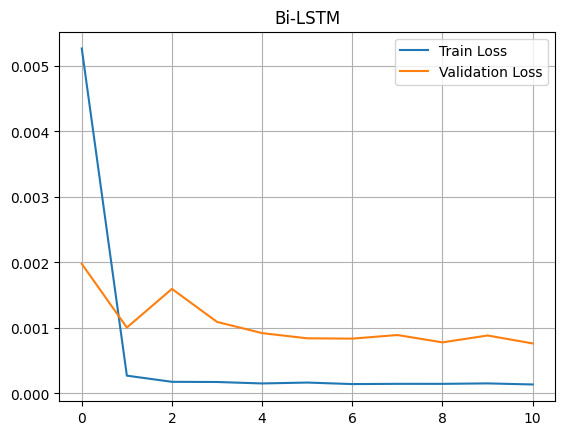

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_bi_lstm_inputinput (In  [(None, 15, 6)]          0         
 putLayer)                                                       
                                                                 
 bidirectional_3 (Bidirectio  (None, 15, 400)          331200    
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 15, 200)          400800    
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 100)              100400    
 nal)                                                            
                                                                 
 dense_layer (Dense)         (None, 1)                 101 

None

In [44]:
# Execute the model

model_new = bi_lstm_model(X_train, y_train, neurons=100, epochs=100, batch_size=64)

#Display model performance
plot_training_vs_overfitting(model_new, 'Bi-LSTM')

display(model_new.model.summary())



### Observation
- Fom the curves, we see it reaches up to 10 epochs (Just like the LSTM model) to avoid overfitting.

17/17 [==============================] - 0s 15ms/step


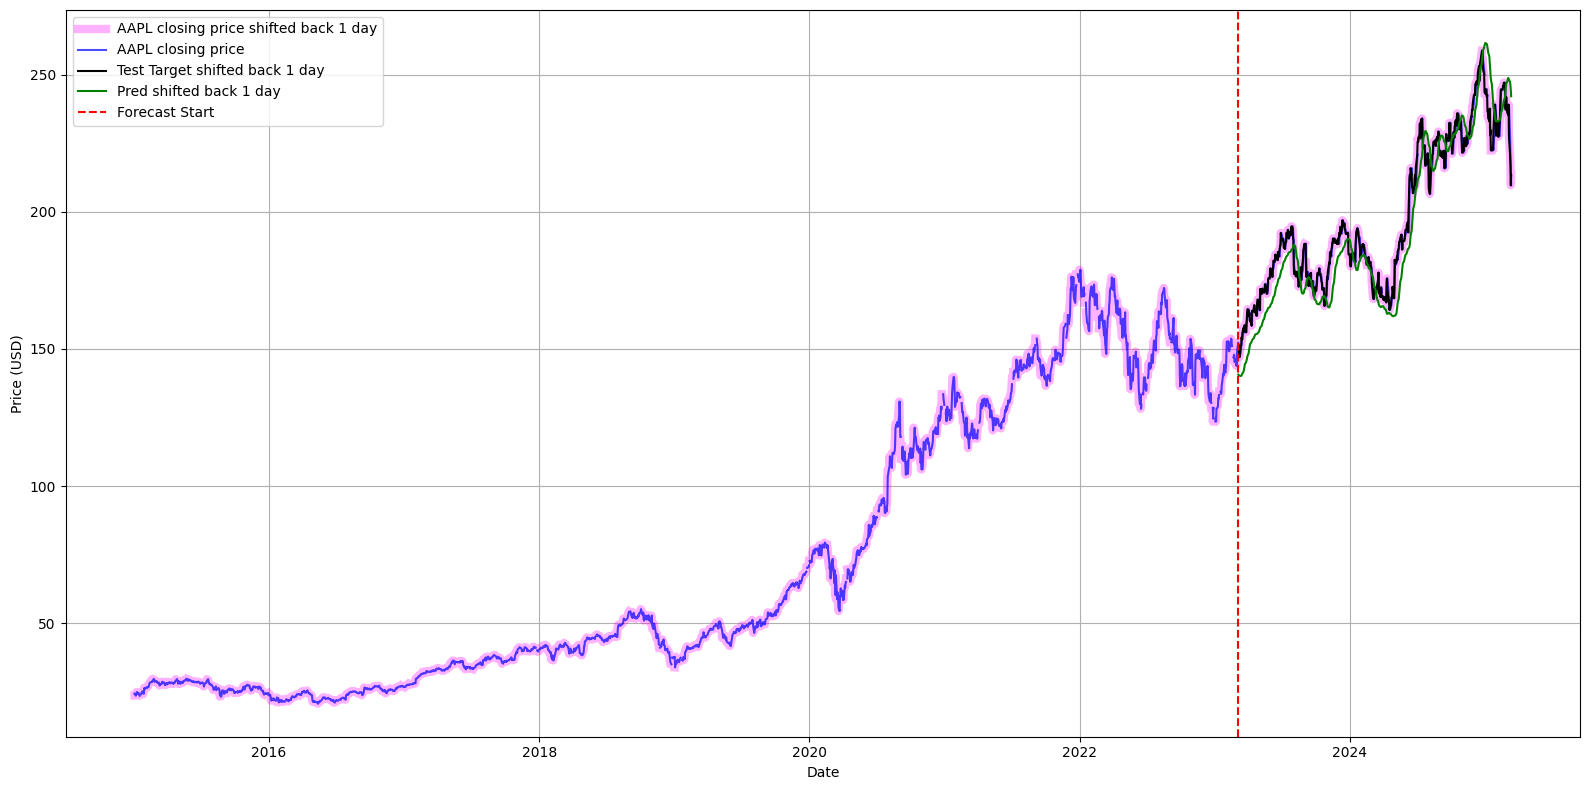

 ... Model Evaluation test data ... 
17/17 [==============================] - 0s 15ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Test Loss:  [0.0018080627778545022, 0.0018080627778545022]

 ... Evaluation Metrics for Regression ... 
MAE: 0.03489997919865385
MSE: 0.0018080626708578754
RMSE: 0.04252132019185053
R-squared: 0.8606174438964987


In [47]:
# Make Predictions
y_pred_new = model_new.model.predict(X_test)

# Plot of Predictions vs Test Data (inversely transormed) 
y_pred_bilstm_trn = pd.DataFrame(mms.inverse_transform(y_pred_new), columns=['y_pred'],  index=df_stock_data_mms.index[train_size+LOOK_BACK:]) 
y_test_bilstm_trn = pd.DataFrame(mms.inverse_transform(y_test), columns=['y_test'],  index=df_stock_data_mms.index[train_size+LOOK_BACK:])  

plt.figure(figsize=(16,8))
# Line plot of the APPL stock data shifted back one day
plt.plot(appl_stock_data['TargetNextClose'], label=f"{chosen_stock} closing price shifted back 1 day", color="magenta", lw=6, alpha=0.3)

# Line plot of the APPL stock data
plt.plot(appl_stock_data['Close'], label=f"{chosen_stock} closing price", color="blue", alpha=0.7)

plt.plot(y_test_bilstm_trn, color = 'black', label = 'Test Target shifted back 1 day')
plt.plot(y_pred_bilstm_trn, color = 'green', label = 'Pred shifted back 1 day')

plt.axvline(x=df_stock_data_mms.index[train_size+LOOK_BACK], color='red', linestyle='--', label='Forecast Start')

plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
mng = plt.get_current_fig_manager()
mng.full_screen_toggle()
plt.tight_layout()
plt.grid(True)
plt.show()

print(" ... Model Evaluation test data ... ")
# Now evaluate the model on the test data
test_loss = model_new.model.evaluate(X_test, y_test)
print("Test Loss: ", test_loss)

model_evaluation_report_regression(y_test,y_pred_new)


## Model Evaluations

| **Method** | **Mean Absolute Error (MAE)** | **Root Mean Squared Error (RMSE)** | **Mean Squared Error (MSE)** | **R^2 score** |
| --- | --- | --- | --- |--- |
| **Deep Learning Based (LSTM)** | 0.025 | 0.032 | 0.001 | 0.92 |
| **ARIMA (AutoRegressive Integrated Moving Average)** | 7.7 | 10.2 | 103.8 | -0.07 |
| **Prophet (Univariate)** | 10.2 | 12.7 | 161.54 | -0.47 |
| **Prophet (Multivariate)** | 1.04 | 1.5 | 2.1 | 0.98 |
| **Deep Learning Based (BiLSTM)** | 0.03 | 0.04 | 0.001 | 0.86 |


## Conclusion:
We see the Deep Learning model BiLSTM provides a very good challenger to the LSTM model; values when based on the r^2 scores (model provides a good fit to the data).
However, BiLSTM takes much longer to run and compile the model when compared to the LSTM, this is due to having a larger architecture and a Bi-directional structure (e.g., processing inputs from past-to-fututre and future-to-past), which it leverages to maintain comprehensive view from both past and future information.
Nevertheless, it is a good model, but requires a lot of parameter finetuning and quite a complex structure which will provide challenges to interpret.